In [81]:
# Import Packages
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  
#pd.set_option('display.expand_frame_repr', False)
#pd.set_option('max_colwidth', -1)

In [82]:
# Import prospective dataset
df= pd.read_excel('H:/RediMinds/DRMahen/Preethi PN_Data validation_2014-2018.xlsx', sheet_name='PN_Data validation_2014-2018')

In [83]:
df['DATEOFSURGERY'] = pd.to_datetime(df['DATEOFSURGERY'], errors = 'coerce')
df['DATEOFSURGERY'].head()

0   2018-11-21
1   2018-04-23
2   2018-03-29
3   2018-08-16
4   2018-04-13
Name: DATEOFSURGERY, dtype: datetime64[ns]

In [84]:
df['YEAROFSURGERY'] = df['DATEOFSURGERY'].map(lambda x: str(x.year))

In [85]:
# Calculate the number of surgeries performed by a center prior to each surgery
df['center_volume'] = ''
for i in range(len(df)):
    dt = df.DATEOFSURGERY[i]
    center_code = df.CENTERCODE[i]
    num_surgeries = len(df.loc[(df.CENTERCODE == center_code)& (df.DATEOFSURGERY<dt)])
    df.loc[i,'center_volume'] = num_surgeries

In [86]:
# import patient list
f = open("../Intra-op Complications/output/models/patient_list.txt", "r")

In [87]:
# create aptient list
patient_list = f.read().splitlines()
f.close()

In [88]:
df = df[df['PATIENTNUMBER'].isin(patient_list)].copy()

In [89]:
df_ori = df.copy()

In [90]:
#check number of patients and columns in Retrospective dataset
print('Number of patients in Combined dataset {}'. format(df.shape[0]))
print('Number of variables in Combined dataset {}'. format(df.shape[1]))

Number of patients in Combined dataset 1690
Number of variables in Combined dataset 163


In [91]:
# reset index for combined dataset
df.reset_index(inplace=True, drop=True)

In [92]:
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 163 columns):
PATIENTNUMBER                         1690 non-null object
PROCNAME                              1690 non-null object
CENTERCODE                            1690 non-null object
SURGEONCODE                           722 non-null object
RECPROGRESS                           1690 non-null object
CREATEDDATE                           1690 non-null object
GENDER                                1690 non-null object
DATEOFBIRTH                           1274 non-null float64
AGEATSURGERY                          1688 non-null float64
MARITALSTATUS                         1543 non-null object
RACE                                  1524 non-null object
EDUCATION                             1481 non-null object
WEIGHT                                1554 non-null float64
HEIGHT                                1552 non-null float64
BMI                                   1574 non-null float64
CLI

In [93]:
#clean Clavien grade
df['CLAVIENGRADE'] = df['CLAVIENGRADE'].map(lambda x: str(x).split(':')[0])

In [94]:
df['CLAVIENGRADE'].value_counts()

Grade 0    1200
nan         346
Grade 1      84
Grade 2      32
Grade 3      26
Grade 4       2
Name: CLAVIENGRADE, dtype: int64

In [95]:
# Clean Surgical and Non- Surgical Complications
df['SURGICALCOMPLICATIONS'] = df['SURGICALCOMPLICATIONS'].map(lambda x: str(x).split(',')[0])
df['NONSURGICALCOMPLICATIONS'] = df['NONSURGICALCOMPLICATIONS'].map(lambda x: str(x).split(',')[0])
print(df['SURGICALCOMPLICATIONS'].unique())
print(df['NONSURGICALCOMPLICATIONS'].unique())

['320' '319' '314' 'nan' '318' '316' '314315320' '317']
['321' 'nan' '324326' '323']


In [96]:
# Dropping Surgical Complciations coded as "Others"
df = df[df['SURGICALCOMPLICATIONS']!='320'].copy()

In [97]:
# Prepare target variable for morbidity
df['POSTOP_COMPLICATIONS'] = 0
df.loc[#((df['POSTOPCOMPLICATION']== 'Complications') & ((df['SURGICALCOMPLICATIONS'].notnull()) | (df['NONSURGICALCOMPLICATIONS'].notnull()))) |
           (df['LENGTHOFSTAYdays']>4)|
           ((df['CLAVIENGRADE']== 'Grade 3') | 
            (df['CLAVIENGRADE']=='Grade 4')),['POSTOP_COMPLICATIONS']] = 1

In [98]:
df = df[df['LENGTHOFSTAYdays']<=14].copy()

In [99]:
# Total Number patients with complications
print('Total number of patients {}'.format(len(df)))
print('Total number of patients with complications {}'.format(df['POSTOP_COMPLICATIONS'].sum()))
print('Total % of patients with complications {:.3f}'.format(df['POSTOP_COMPLICATIONS'].sum()/len(df)))

Total number of patients 1602
Total number of patients with complications 346
Total % of patients with complications 0.216


### Define numeric columns and identify missing values

In [100]:
# List of columns tobre converted to numeric
numeric_col_list = ['AGEATSURGERY',
'WEIGHT',
'HEIGHT',
'BMI',
'CLINICALSIZEmm',
'PREOPHB',
'PREOPHT',
'PREOPWBC',
'PREOPCREAT',
'PREOPGFR',
'PREOPEGFR',
'PREOPERPF',
'NOOFLESIONS',
'BLOODLOSSml',
'POSTOPHB_Day1',
'POSTOPHT_Day1',
'POSTOPCreat_Day1',
'POSTOPEGFR_Day1',
'POSTOPWBC_Day1',
'POSTOPHB_Day2',
'POSTOPHT_Day2',
'POSTOPCreat_Day2',
'POSTOPEGFR_Day2',
'POSTOPWBC_Day2',
'POSTOPHB_Day3',
'POSTOPHT_Day3',
'POSTOPCreat_Day3',
'POSTOPEGFR_Day3',
'POSTOPWBC_Day3',
'LENGTHOFSTAYdays',
'PATHOLOGICALTUMORSIZE',
'MINTHICKNESSMARGIN',
'MAXTHICKNESSMARGIN',
'SARCOMATOIDDIFF_A',
'NO_OF_NODE_TAKEN',
'LASTFOLLOWUPDURATION',
'CHARLSONSCORE',
'CHARLSONAGEADJUSTSCORE',
'PADUASCORE',
'ISCHEMIATIMEmin',
'OPERATIVETIMEmin'
] 

### Define Categorical columns

In [101]:
cat_col = ['PROCNAME',
'CENTERCODE',
'SURGEONCODE',
'RECPROGRESS',
'GENDER',
'MARITALSTATUS',
'RACE',
'EDUCATION',
'ECOG',
'SYMPTOMS',
'SOLITARYKIDNEY',
'TYPEOFSOLITARYKIDNEY',
'BILATERALITYOFTUMOR',
'SIDEOFTUMOR',
'SIDEOFSURGERY',
'PREOPMULTIFOCALITY',
'FACE',
'TUMORlOCATION',

'PADUARISK',
'POLARLOCATION',
'RIMLOCATION',
'RENALSINUS',
'UCSINVASION',
'EXOPHYTICRATE',
'CLINICALSIZEGROUP',
'CT',
'CN',
'CM',
'R.E.N.A.L.NEPHROSCORE',
'R.E.N.A.L.NEPHRORISKSTRATIFICATION',
'RADIUSmaximaldiameterincm',
'EXOPHYTICENDOPHYTICPROPERTIES',
'NEARNESSOFTUMOUR',
'ANTERIORORPOSTERIOR',
'LOCATIONTOPOLARLINE',
'TumorConsistencyonImaging',
'BosniakClassification',
'ASASCORE',
'PARTIALNEPHROINDICATION',
'MULTIFOCALITY',
'ImagingFeaturesofotherexcisedtumor',
'Consistencyoftheotherexcisedtumors',
'ACCESS',
'DAVINCIMODEL',
'ROBOTICSARMS',
'ASSISTENTTROCARS',
'DUALCONSOLE',
'PRIMARYSURGEON',
'ISCHEMIA',
'CLAMPARTERY',
'SELECTIVEARTERIALCLAMPING',
'CLAMPVEIN',
'EARLYUNCLAMPING',
'FLUORESCENCE',
'INNERRENORRHAPHY',
'OUTERRENORRHAPHY',
'UCSREPAIR',
'HAEMOSTATICAGENTS',
'HAEMOSTATICDetails',
'LYMPHNODEDISSECTIONLND',
'INTRAOPTRANSUFUSION',
'SURGICALCONSIDERATIONS',
'INTRAOPCOMPLICATION',
'INTRAOPCOMPLICATIONS',
'NeedtoConverttoRadicalNephrectomy',
'TREATMENTOFCOMPLICATION',
'POSTOPCOMPLICATION',
'SURGICALCOMPLICATIONS',
'NONSURGICALCOMPLICATIONS',
'POSTOPTREATMENTOFCOMPLICATION',
'CLAVIENGRADE',
'MULITIFOCALITY',
'PATHOLOGY',
'HYSTOTYPEMALIGNANAT',
'HYSTOTYPEMALIGNANATYES',
'HYSTOTYPEBENIGN',
'HYSTOTYPEBENIGNYES',
'FUHRMANGRADING',
'SARCOMATOIDDIFF',
'NECROSIS',
'MICROVENOUSINVASION',
'UCSINVASION_A',
'PERIRENALFATINVASION',
'HilarFatInvasion',
'SINUSFATINVASION',
'MICSCORE',
'ADRENALINVASION',
'GEROTAINVASION',
'RenalVeinInvasion',
'VENOUSTHROMBUS',
'SURGICALMARGIN',
'UNIFOCALMULTIFOCAL',
'NO_OF_NODE_POSITIVE',
'SITEOFPOSITIVENODE',
'TREATMENTPSM',
'PT',
'PN',
'OTHERTUMORS',
'LASTFOLLOWUPSTATUS',
'LASTFOLLOWUPRECURRENCE',
'LASTTREATMENTOFRECURRENCE'
]

### Select Variables for analysis

In [102]:
post_op_col = [
'PATIENTNUMBER',
#'PROCNAME',
'CENTERCODE',
#'SURGEONCODE',
#'RECPROGRESS',
#'CREATEDDATE',
'GENDER',
#'DATEOFBIRTH',
'AGEATSURGERY',
'MARITALSTATUS',
'RACE',
'EDUCATION',
#'WEIGHT',
#'HEIGHT',
'BMI',
'CLINICALSIZEmm',
'ECOG',
'CHARLSONSCORE',
#'CHARLSONAGEADJUSTSCORE',
'SYMPTOMS',
'SOLITARYKIDNEY',
'TYPEOFSOLITARYKIDNEY',
'BILATERALITYOFTUMOR',
'SIDEOFTUMOR',
'SIDEOFSURGERY',
'PREOPMULTIFOCALITY',
'FACE',
'TUMORlOCATION',
'PREOPHB',
'PREOPHT',
'PREOPWBC',
'PREOPCREAT',
'PREOPGFR',
'PREOPEGFR',
'PREOPERPF',
#'PADUASCORE',
'PADUARISK',
'POLARLOCATION',
'RIMLOCATION',
'RENALSINUS',
#'UCSINVASION',
'EXOPHYTICRATE',
'CLINICALSIZEGROUP',
'CT',
'CN',
'CM',
#'R.E.N.A.L.NEPHROSCORE',
'R.E.N.A.L.NEPHRORISKSTRATIFICATION',
'RADIUSmaximaldiameterincm',
'EXOPHYTICENDOPHYTICPROPERTIES',
'NEARNESSOFTUMOUR',
'ANTERIORORPOSTERIOR',
'LOCATIONTOPOLARLINE',
'TumorConsistencyonImaging',
'BosniakClassification',
#'DATEOFSURGERY',
'ASASCORE',
'PARTIALNEPHROINDICATION',
'MULTIFOCALITY',
'NOOFLESIONS',
#'ImagingFeaturesofotherexcisedtumor', #too many categories
'Consistencyoftheotherexcisedtumors',
'ACCESS',
'DAVINCIMODEL',
'ROBOTICSARMS',
'ASSISTENTTROCARS',
'DUALCONSOLE',
#'PRIMARYSURGEON',
'OPERATIVETIMEmin',
'ISCHEMIA',
'CLAMPARTERY',
'SELECTIVEARTERIALCLAMPING',
'CLAMPVEIN',
'EARLYUNCLAMPING',
'FLUORESCENCE',
'INNERRENORRHAPHY',
'OUTERRENORRHAPHY',
'ISCHEMIATIMEmin',
'UCSREPAIR',
'HAEMOSTATICAGENTS',
#'HAEMOSTATICDetails', # too many values
'LYMPHNODEDISSECTIONLND',
'BLOODLOSSml',
'INTRAOPTRANSUFUSION',
#'SURGICALCONSIDERATIONS', too many values
'INTRAOPCOMPLICATION',
'INTRAOPCOMPLICATIONS',
'NeedtoConverttoRadicalNephrectomy',
    
'center_volume',    
'POSTOP_COMPLICATIONS' # Target Variable    
]

### Data Cleaning

In [103]:
# function to clean operative time which contains a mix of time and numeric data i.e. '2:30' & '120.6'
def clean_oprerative_time(t):
    if ':' in t:
        x = float(t.split(':')[0])*60 + float(t.split(':')[1])
    else:
        x = float(t)
    return x

# clean operative time 
df['OPERATIVETIMEmin'] = df['OPERATIVETIMEmin'].map(lambda x: clean_oprerative_time(str(x)))

In [104]:
# Clean INTRAOPCOMPLICATIONS consider first code as primary complication
df['INTRAOPCOMPLICATIONS'] = df['INTRAOPCOMPLICATIONS'].map(lambda x: str(x).split(',')[0])

In [105]:
# Define Intra-op Complications
df['INTRA_OP_COMPLICATIONS'] = 0

# selecting indicator == 'Yes' and code vailability or Intra-op Bloos transfusion>1 unit as Intra-op complication
df.loc[((df['INTRAOPCOMPLICATIONS'].notnull()) & (df['INTRAOPCOMPLICATION'] == 'Yes'))|(df['INTRAOPTRANSUFUSION']=='>1 Unit') ,['INTRA_OP_COMPLICATIONS']] = 1

In [106]:
#Drop INTRAOPCOMPLICATION as it has been replaced by INTRA_OP_COMPLICATIONS
df.drop(labels=['INTRAOPCOMPLICATION'],axis = 'columns' ,inplace=True)
post_op_col.remove('INTRAOPCOMPLICATION') # remove the varibale from list of predictors for post-op complications

In [107]:
# Convert columns in numeric_col_list to numeric and invalid values are set NaN 
for col in numeric_col_list:
    df[col]= pd.to_numeric(df[col], errors='coerce')

In [108]:
# Summary of numeric columns
df.describe(include = [np.number]).round(2)

,DATEOFBIRTH,AGEATSURGERY,WEIGHT,HEIGHT,BMI,CLINICALSIZEmm,CHARLSONSCORE,CHARLSONAGEADJUSTSCORE,PREOPHB,PREOPHT,PREOPWBC,PREOPCREAT,PREOPGFR,PREOPEGFR,PREOPERPF,PADUASCORE,LOCATIONTOPOLARLINE,NOOFLESIONS,OPERATIVETIMEmin,ISCHEMIATIMEmin,BLOODLOSSml,POSTOPHB_Day1,POSTOPHT_Day1,POSTOPCreat_Day1,POSTOPEGFR_Day1,POSTOPWBC_Day1,POSTOPHB_Day2,POSTOPHT_Day2,POSTOPCreat_Day2,POSTOPEGFR_Day2,POSTOPWBC_Day2,POSTOPHB_Day3,POSTOPHT_Day3,POSTOPCreat_Day3,POSTOPEGFR_Day3,POSTOPWBC_Day3,LENGTHOFSTAYdays,PATHOLOGICALTUMORSIZE,MINTHICKNESSMARGIN,MAXTHICKNESSMARGIN,FUHRMANGRADING,SARCOMATOIDDIFF_A,MICSCORE,NO_OF_NODE_TAKEN,LASTFOLLOWUPDURATION,Year,center_volume,POSTOP_COMPLICATIONS,INTRA_OP_COMPLICATIONS
count,1190.00,1600.00,1472.00,1470.00,1489.00,1558.00,1523.00,1395.00,1574.00,1578.00,1436.00,1591.00,99.00,1297.00,94.00,1410.00,1438.00,1582.00,1529.00,1515.00,1572.00,684.00,844.00,1049.00,794.00,551.00,370.00,405.00,552.00,384.00,315.00,285.00,291.00,466.00,262.00,276.00,1602.00,1571.00,1053.00,468.00,1391.00,963.00,1213.00,1388.00,1076.00,1601.00,1602.00,1602.00,1602.00
mean,1957.11,56.77,89.05,163.46,27.61,33.73,1.26,3.29,19.01,45.57,6857.22,2.18,659.92,81.10,878.44,8.45,1.92,1.04,174.30,20.42,189.58,64.80,73.29,35.36,128.88,2536.25,168.45,170.79,105.99,226.23,3438.25,250.52,294.14,142.42,315.34,3385.41,3.27,12.91,79.70,204.13,160.53,20.66,0.19,1.52,17.32,2014.05,161.70,0.22,0.06
std,13.18,12.79,54.73,41.15,4.88,44.81,1.80,2.14,70.08,87.89,2245.20,35.38,451.03,18.61,290.96,1.73,0.83,0.26,74.43,37.98,217.22,220.49,195.88,181.75,231.35,4643.70,358.90,342.67,306.27,353.19,5394.42,423.79,431.52,348.32,414.04,4446.61,1.84,29.39,263.95,393.98,364.54,162.97,0.39,37.91,20.90,3.00,133.80,0.41,0.23
min,1925.00,16.00,7.71,1.70,15.10,0.00,0.00,0.00,10.00,0.34,4.00,0.40,35.00,34.00,43.50,2.00,1.00,0.00,24.00,0.00,0.00,7.40,0.28,0.46,16.84,5.20,0.00,0.00,0.00,0.00,2.10,0.00,0.00,0.00,0.00,4.70,0.00,0.00,0.00,0.00,1.00,-999.00,0.00,0.00,0.00,2006.00,0.00,0.00,0.00
25%,1948.00,48.00,68.47,160.00,24.16,21.25,0.00,2.00,13.10,37.70,5600.00,0.78,83.00,67.15,999.00,7.00,1.00,1.00,132.00,14.00,50.00,11.20,32.08,1.00,54.14,9.75,10.82,30.30,0.90,52.96,9.80,11.00,31.70,0.89,60.23,9.70,2.00,2.50,1.00,2.00,2.00,0.00,0.00,0.00,3.00,2012.00,50.00,0.00,0.00
50%,1956.00,58.00,79.00,169.00,26.87,30.00,1.00,3.00,14.00,41.60,6800.00,0.90,999.00,80.44,999.00,8.00,2.00,1.00,163.00,18.00,100.00,12.50,36.00,1.00,68.00,12.60,12.20,35.70,1.12,70.00,12.50,12.20,37.00,1.10,74.71,999.00,3.00,4.00,2.00,5.00,2.00,0.00,0.00,0.00,9.05,2015.00,124.00,0.00,0.00
75%,1966.00,66.00,92.00,176.00,30.55,41.00,2.00,4.00,15.10,44.68,8200.00,1.05,999.00,94.00,999.00,10.00,3.00,1.00,198.00,23.00,200.00,13.42,39.02,1.20,83.74,999.00,14.10,41.00,1.47,98.96,6960.00,14.80,999.00,1.42,999.00,6010.00,4.00,20.00,5.00,30.00,3.00,0.00,0.00,0.00,23.00,2017.00,259.75,0.00,0.00
max,1998.00,87.00,999.00,999.00,42.30,999.00,19.00,18.00,999.00,999.00,12840.00,999.00,999.00,136.49,999.00,13.00,3.00,4.00,999.00,999.00,2000.00,999.00,999.00,999.00,999.00,19610.00,999.00,999.00,999.00,999.00,27780.00,999.00,999.00,999.00,999.00,16060.00,13.00,999.00,999.00,999.00,999.00,999.00,1.00,999.00,101.00,2018.00,524.00,1.00,1.00


In [109]:
#replace missing values such as 999 in the dataframe with NaN
df = df.replace([99,999,9999,99999,999999,-99,-999,-9999,-99999,-999999],np.nan)

In [110]:
# replacing negative numbers in the dataframe with nan as given variables cannot contain negative numbers
for col in list(df.select_dtypes('float64')):
    df[col] = df[col].apply(lambda x: np.nan if x<0 else x)

In [111]:
# Summary of numeric columns - to check missing values such as 99, 999, 999 have been replaced
df.describe(include = [np.number]).round(2)

,DATEOFBIRTH,AGEATSURGERY,WEIGHT,HEIGHT,BMI,CLINICALSIZEmm,CHARLSONSCORE,CHARLSONAGEADJUSTSCORE,PREOPHB,PREOPHT,PREOPWBC,PREOPCREAT,PREOPGFR,PREOPEGFR,PREOPERPF,PADUASCORE,LOCATIONTOPOLARLINE,NOOFLESIONS,OPERATIVETIMEmin,ISCHEMIATIMEmin,BLOODLOSSml,POSTOPHB_Day1,POSTOPHT_Day1,POSTOPCreat_Day1,POSTOPEGFR_Day1,POSTOPWBC_Day1,POSTOPHB_Day2,POSTOPHT_Day2,POSTOPCreat_Day2,POSTOPEGFR_Day2,POSTOPWBC_Day2,POSTOPHB_Day3,POSTOPHT_Day3,POSTOPCreat_Day3,POSTOPEGFR_Day3,POSTOPWBC_Day3,LENGTHOFSTAYdays,PATHOLOGICALTUMORSIZE,MINTHICKNESSMARGIN,MAXTHICKNESSMARGIN,FUHRMANGRADING,SARCOMATOIDDIFF_A,MICSCORE,NO_OF_NODE_TAKEN,LASTFOLLOWUPDURATION,Year,center_volume,POSTOP_COMPLICATIONS,INTRA_OP_COMPLICATIONS
count,1190.00,1600.00,1467.00,1468.00,1489.00,1555.00,1523.00,1395.00,1566.00,1565.00,1425.00,1589.00,36.00,1291.00,14.00,1410.00,1438.00,1582.00,1521.00,1513.00,1569.00,648.00,808.00,1013.00,741.00,514.00,312.00,346.00,494.00,315.00,299.00,216.00,212.00,400.00,190.00,209.00,1602.00,1570.00,971.00,375.00,1170.00,936.00,1213.00,1386.00,1076.00,1601.00,1598.00,1602.00,1602.00
mean,1957.11,56.77,87.17,162.33,27.61,31.87,1.26,3.29,14.00,37.65,6902.44,0.93,66.53,81.02,189.54,8.45,1.92,1.04,171.74,19.13,188.04,12.90,32.04,1.11,67.86,2646.91,14.05,29.56,1.14,65.53,3568.77,11.42,31.47,1.08,65.74,4150.44,3.27,12.29,3.92,11.80,2.16,0.03,0.19,0.09,17.32,2014.05,161.86,0.22,0.06
std,13.18,12.79,36.16,27.25,4.88,14.49,1.80,2.14,1.42,13.07,2193.79,0.20,21.78,18.61,71.30,1.73,0.83,0.26,57.57,13.28,214.52,7.91,12.26,0.36,20.64,4789.21,16.41,14.03,0.45,24.02,5506.87,2.29,24.39,0.43,22.37,4870.19,1.84,15.63,10.36,54.17,0.67,0.52,0.39,0.57,20.90,3.00,133.93,0.41,0.23
min,1925.00,16.00,7.71,1.70,15.10,0.00,0.00,0.00,10.00,0.34,4.00,0.40,35.00,34.00,43.50,2.00,1.00,0.00,24.00,0.00,0.00,7.40,0.28,0.46,16.84,5.20,0.00,0.00,0.00,0.00,2.10,0.00,0.00,0.00,0.00,4.70,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,2006.00,0.00,0.00,0.00
25%,1948.00,48.00,68.30,160.00,24.16,21.00,0.00,2.00,13.10,37.60,5600.00,0.78,46.75,67.00,145.00,7.00,1.00,1.00,132.00,14.00,50.00,11.00,31.90,0.99,53.23,9.50,10.70,28.85,0.89,49.86,9.40,10.50,29.37,0.84,54.25,8.80,2.00,2.50,1.00,1.55,2.00,0.00,0.00,0.00,3.00,2012.00,50.00,0.00,0.00
50%,1956.00,58.00,79.00,169.00,26.87,30.00,1.00,3.00,14.00,41.60,6800.00,0.90,70.20,80.26,203.00,8.00,2.00,1.00,163.00,18.00,100.00,12.30,35.80,1.00,65.00,12.00,11.80,33.95,1.08,64.00,12.10,11.90,34.00,1.04,66.00,15.90,3.00,4.00,2.00,3.00,2.00,0.00,0.00,0.00,9.05,2015.00,124.00,0.00,0.00
75%,1966.00,66.00,92.00,176.00,30.55,41.00,2.00,4.00,15.08,44.50,8210.00,1.05,86.50,93.97,230.50,10.00,3.00,1.00,197.00,23.00,200.00,13.10,38.60,1.18,80.08,3400.00,13.00,38.00,1.31,81.00,7410.00,12.82,37.38,1.21,78.00,8700.00,4.00,20.00,4.00,8.00,3.00,0.00,0.00,0.00,23.00,2017.00,260.75,0.00,0.00
max,1998.00,87.00,298.00,198.12,42.30,71.00,19.00,18.00,17.80,53.70,12840.00,1.57,116.80,136.49,340.00,13.00,3.00,4.00,546.00,320.00,2000.00,129.00,49.30,3.90,155.50,19610.00,136.00,51.00,5.29,157.70,27780.00,15.20,332.00,4.64,150.00,16060.00,13.00,110.00,240.00,979.00,4.00,15.00,1.00,11.00,101.00,2018.00,524.00,1.00,1.00


In [112]:
# Correcting the units for erroroneously entered data
def clean_WBC(x):
    if len(str(x))<6:
        x = x*1000
    return x
        

# if the value of PRE-OP WBC value contains is less the 4 digits then multiply it by 1000
df['PREOPWBC'] = df['PREOPWBC'].apply(lambda x: clean_WBC(x))

# if the value of POST-OP WBC_Day 1 value contains is less the 4 digits then multiply it by 1000
df['POSTOPWBC_Day1'] = df['POSTOPWBC_Day1'].apply(lambda x: clean_WBC(x))

# if the value of POST-OP WBC_Day 2 value contains is less the 4 digits then multiply it by 1000
df['POSTOPWBC_Day2'] = df['POSTOPWBC_Day2'].apply(lambda x: clean_WBC(x))

# if the value of POST-OP WBC_Day 2 value contains is less the 4 digits then multiply it by 1000
df['POSTOPWBC_Day3'] = df['POSTOPWBC_Day3'].apply(lambda x: clean_WBC(x))

In [113]:
# Correcting the units for erroroneously entered data for PREOPHB
df['PREOPHB'] = df['PREOPHB'].apply(lambda x: x*100 if x<10 else x)

# Correcting the units for erroroneously entered data for PREOPHB
df['PREOPHT'] = df['PREOPHT'].apply(lambda x: x*100 if x<10 else x)

In [114]:
# Selecting dataframe relevant columsn for analysis
df = df[post_op_col].copy()

In [115]:
#Keep columns having less than 50% missing data
print("Total number of columns before removing columns with more than 50% missing data: {}".format(len(list(df))))

df = df[df.columns[df.isnull().mean() <= 0.50]].copy()

print("Total number of columns left after removing columns with more than 50% missing data: {}".format(len(list(df))))

Total number of columns before removing columns with more than 50% missing data: 73
Total number of columns left after removing columns with more than 50% missing data: 65


In [116]:
# select target variable
target = 'POSTOP_COMPLICATIONS'

In [117]:
df.describe()

,AGEATSURGERY,BMI,CLINICALSIZEmm,CHARLSONSCORE,PREOPHB,PREOPHT,PREOPWBC,PREOPCREAT,PREOPEGFR,LOCATIONTOPOLARLINE,NOOFLESIONS,OPERATIVETIMEmin,ISCHEMIATIMEmin,BLOODLOSSml,center_volume,POSTOP_COMPLICATIONS
count,1600.000000,1489.000000,1555.000000,1523.000000,1566.000000,1565.000000,1425.000000,1589.000000,1291.000000,1438.000000,1582.000000,1521.000000,1513.000000,1569.000000,1598.000000,1602.000000
mean,56.767500,27.611387,31.869582,1.262640,14.000868,41.826709,7114.863818,0.927844,81.015102,1.916551,1.044880,171.737673,19.127369,188.035054,161.856070,0.215980
std,12.785905,4.875161,14.488933,1.801763,1.418317,4.197366,1865.068912,0.203869,18.611653,0.828337,0.258705,57.573273,13.281617,214.520557,133.930306,0.411629
min,16.000000,15.100000,0.000000,0.000000,10.000000,29.000000,1840.000000,0.400000,34.000000,1.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,24.160000,21.000000,0.000000,13.100000,39.100000,5700.000000,0.780000,67.000000,1.000000,1.000000,132.000000,14.000000,50.000000,50.000000,0.000000
50%,58.000000,26.870000,30.000000,1.000000,14.000000,42.100000,6920.000000,0.900000,80.260000,2.000000,1.000000,163.000000,18.000000,100.000000,124.000000,0.000000
75%,66.000000,30.550000,41.000000,2.000000,15.075000,45.000000,8300.000000,1.050000,93.970000,3.000000,1.000000,197.000000,23.000000,200.000000,260.750000,0.000000
max,87.000000,42.300000,71.000000,19.000000,17.800000,53.700000,12840.000000,1.570000,136.493592,3.000000,4.000000,546.000000,320.000000,2000.000000,524.000000,1.000000


In [118]:
numeric_stats = df.describe()

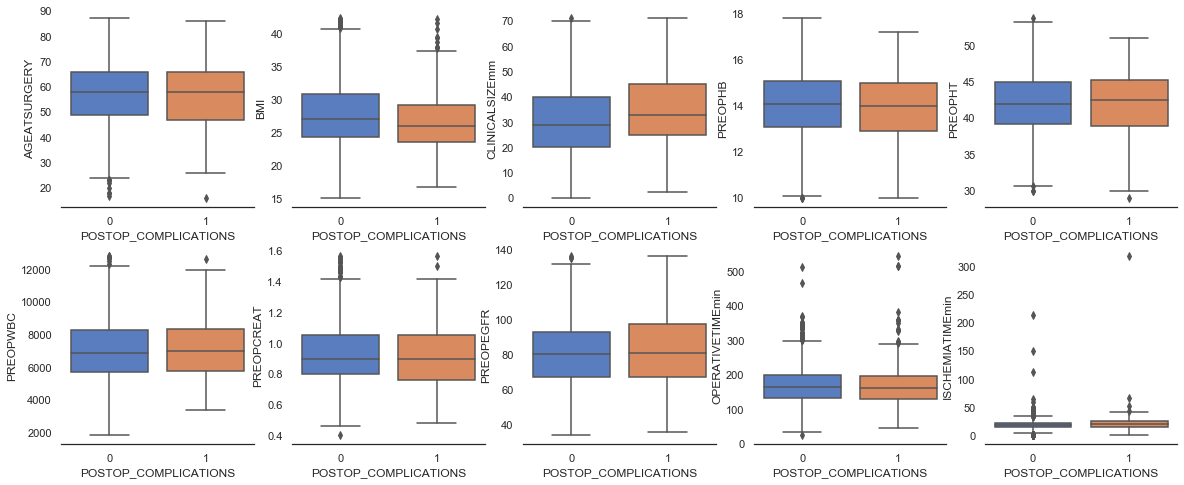

In [119]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)
f, axes = plt.subplots(2, 5, figsize=(20, 8))
sns.despine(left=True)
sns.boxplot(data = df, y = 'AGEATSURGERY', x = target,ax=axes[0, 0])
sns.boxplot(data = df, y = 'BMI', x = target, ax=axes[0, 1])
sns.boxplot(data = df, y = 'CLINICALSIZEmm', x = target, ax=axes[0, 2])
sns.boxplot(data = df, y = 'PREOPHB', x = target, ax=axes[0, 3])
sns.boxplot(data = df, y = 'PREOPHT', x = target, ax=axes[0, 4])
sns.boxplot(data = df, y = 'PREOPWBC', x = target, ax=axes[1, 0])
sns.boxplot(data = df, y = 'PREOPCREAT', x = target, ax=axes[1, 1])
sns.boxplot(data = df, y = 'PREOPEGFR', x = target, ax=axes[1, 2])
sns.boxplot(data = df, y = 'OPERATIVETIMEmin', x = target, ax=axes[1, 3])
sns.boxplot(data = df, y = 'ISCHEMIATIMEmin', x = target, ax=axes[1, 4])

In [120]:
# Check the number of outliers
clean_cols = ['BMI','CLINICALSIZEmm','PREOPHB','PREOPHT','PREOPWBC','PREOPCREAT','PREOPEGFR','OPERATIVETIMEmin','ISCHEMIATIMEmin']
for i in clean_cols:
    q1 = numeric_stats.loc['25%'][i]
    q3 = numeric_stats.loc['75%'][i]
    IQR = q3-q1
    LL = q1-(1.5*IQR)
    UL = q3+(1.5*IQR)
    print('{:<20s} {:>4d} {:>4d}'.format(i,len(df.loc[(df[i]>=UL)]),len(df.loc[(df[i]<=LL)])), 'UL-LL {:>4.2f}-{:>4.2f}'.format(UL,LL))

BMI                    24    0 UL-LL 40.14-14.57
CLINICALSIZEmm          3    0 UL-LL 71.00--9.00
PREOPHB                 0    7 UL-LL 18.04-10.14
PREOPHT                 0    5 UL-LL 53.85-30.25
PREOPWBC                9    0 UL-LL 12200.00-1800.00
PREOPCREAT             22    0 UL-LL 1.46-0.38
PREOPEGFR               4    0 UL-LL 134.43-26.55
OPERATIVETIMEmin       53    1 UL-LL 294.50-34.50
ISCHEMIATIMEmin        53   78 UL-LL 36.50-0.50


In [121]:
#replacing inaccurate readings with missing values
clean_cols = ['OPERATIVETIMEmin','ISCHEMIATIMEmin']
for i in clean_cols:
    q1 = numeric_stats.loc['25%'][i]
    q3 = numeric_stats.loc['75%'][i]
    IQR = q3-q1
    LL = q1-(1.5*IQR)
    UL = q3+(1.5*IQR)
    df.drop(df.loc[(df[i]<=LL)|(df[i]>=UL),[i]].index, inplace=True)

In [122]:
df.describe()

,AGEATSURGERY,BMI,CLINICALSIZEmm,CHARLSONSCORE,PREOPHB,PREOPHT,PREOPWBC,PREOPCREAT,PREOPEGFR,LOCATIONTOPOLARLINE,NOOFLESIONS,OPERATIVETIMEmin,ISCHEMIATIMEmin,BLOODLOSSml,center_volume,POSTOP_COMPLICATIONS
count,1429.000000,1324.000000,1388.000000,1356.000000,1398.000000,1397.000000,1260.000000,1420.000000,1163.000000,1276.000000,1411.000000,1357.000000,1343.000000,1400.000000,1427.000000,1431.000000
mean,56.761372,27.506187,31.519236,1.171829,13.994392,41.788690,7110.437254,0.927743,81.023047,1.904389,1.043232,163.389831,18.696307,180.374286,156.352488,0.218728
std,12.765599,4.785238,14.271235,1.782027,1.418450,4.206514,1875.362715,0.203122,18.608312,0.829994,0.250337,45.491423,6.186458,208.253560,131.219011,0.413528
min,17.000000,15.100000,0.000000,0.000000,10.000000,29.000000,1840.000000,0.460000,34.000000,1.000000,0.000000,35.000000,1.000000,0.000000,0.000000,0.000000
25%,48.000000,24.195000,21.000000,0.000000,13.000000,39.000000,5700.000000,0.780000,67.000000,1.000000,1.000000,130.000000,14.000000,50.000000,48.000000,0.000000
50%,57.000000,26.810000,30.000000,1.000000,14.000000,42.000000,6925.000000,0.900000,80.170407,2.000000,1.000000,160.000000,18.000000,100.000000,121.000000,0.000000
75%,66.000000,30.360000,41.000000,2.000000,15.000000,45.000000,8300.000000,1.050000,93.845000,3.000000,1.000000,189.000000,23.000000,200.000000,235.500000,0.000000
max,87.000000,42.300000,71.000000,19.000000,17.800000,53.700000,12840.000000,1.570000,136.493592,3.000000,3.000000,293.000000,36.000000,2000.000000,524.000000,1.000000


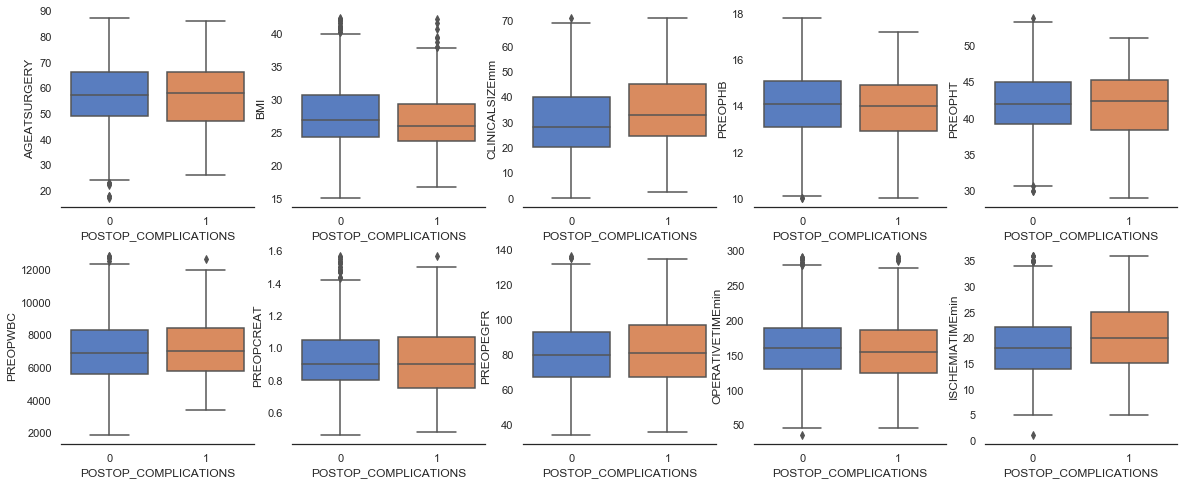

In [123]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)
f, axes = plt.subplots(2, 5, figsize=(20, 8))
sns.despine(left=True)
sns.boxplot(data = df, y = 'AGEATSURGERY', x = target,ax=axes[0, 0])
sns.boxplot(data = df, y = 'BMI', x = target, ax=axes[0, 1])
sns.boxplot(data = df, y = 'CLINICALSIZEmm', x = target, ax=axes[0, 2])
sns.boxplot(data = df, y = 'PREOPHB', x = target, ax=axes[0, 3])
sns.boxplot(data = df, y = 'PREOPHT', x = target, ax=axes[0, 4])
sns.boxplot(data = df, y = 'PREOPWBC', x = target, ax=axes[1, 0])
sns.boxplot(data = df, y = 'PREOPCREAT', x = target, ax=axes[1, 1])
sns.boxplot(data = df, y = 'PREOPEGFR', x = target, ax=axes[1, 2])
sns.boxplot(data = df, y = 'OPERATIVETIMEmin', x = target, ax=axes[1, 3])
sns.boxplot(data = df, y = 'ISCHEMIATIMEmin', x = target, ax=axes[1, 4])

In [124]:
# The percentage of missing data
df.isnull().mean()

PATIENTNUMBER           0.000000
CENTERCODE              0.000000
GENDER                  0.000000
AGEATSURGERY            0.001398
MARITALSTATUS           0.099930
                          ...   
BLOODLOSSml             0.021663
INTRAOPTRANSUFUSION     0.058001
INTRAOPCOMPLICATIONS    0.000000
center_volume           0.002795
POSTOP_COMPLICATIONS    0.000000
Length: 65, dtype: float64

In [125]:
# Calculate number missing values per row
df.reset_index(inplace=True, drop=True)
missing = {}

for i in range(len(df)):
    miss_cnt = 0
    for col in df.columns:
        if pd.isna(df[col][i]) == True:
            miss_cnt = miss_cnt+1
    df.loc[i,'Missing'] = miss_cnt

In [126]:
# calculate number of records with over 25% missing data
print("Total Records {}".format(len(df)))
print("Records with >=25% missing data {}".format(sum(df['Missing']<= round((len(df.columns)-2)*.30))))
print("Records to be dropped {}".format(len(df) - sum(df['Missing']<= round((len(df.columns)-2)*.30))))

Total Records 1431
Records with >=25% missing data 1406
Records to be dropped 25


In [127]:
# Chekc the number of missing values for each variables if records with a certain missing threshold were removed
df[df['Missing']<= round((len(df.columns)-2)*.30) ].isnull().mean()

PATIENTNUMBER           0.000000
CENTERCODE              0.000000
GENDER                  0.000000
AGEATSURGERY            0.001422
MARITALSTATUS           0.086060
                          ...   
INTRAOPTRANSUFUSION     0.041963
INTRAOPCOMPLICATIONS    0.000000
center_volume           0.002845
POSTOP_COMPLICATIONS    0.000000
Missing                 0.000000
Length: 66, dtype: float64

In [128]:
#removing patients with more than 70% missing data
df = df[df['Missing']<= round((len(df.columns)-2)*.30) ].copy()

In [129]:
df[df.columns[df.isnull().mean() <= 0.15]].isnull().mean()

PATIENTNUMBER           0.000000
CENTERCODE              0.000000
GENDER                  0.000000
AGEATSURGERY            0.001422
MARITALSTATUS           0.086060
                          ...   
INTRAOPTRANSUFUSION     0.041963
INTRAOPCOMPLICATIONS    0.000000
center_volume           0.002845
POSTOP_COMPLICATIONS    0.000000
Missing                 0.000000
Length: 62, dtype: float64

In [130]:
df = df[df.columns[df.isnull().mean() <= 0.15]]

In [131]:
# Replcaing missing values in categorical column with NA
for k in cat_col:
    if k in df.columns:
        df[k].fillna('NA',inplace = True)

In [132]:
## Replacing missing values in numerical columns with their respective mean 
#for k in numeric_col_list:
#    if k in df.columns:
#        df[k].fillna(round(df[k].mean()), inplace = True)

In [133]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 0 to 1430
Data columns (total 62 columns):
PATIENTNUMBER                         1406 non-null object
CENTERCODE                            1406 non-null object
GENDER                                1406 non-null object
AGEATSURGERY                          1404 non-null float64
MARITALSTATUS                         1406 non-null object
RACE                                  1406 non-null object
EDUCATION                             1406 non-null object
BMI                                   1318 non-null float64
CLINICALSIZEmm                        1363 non-null float64
CHARLSONSCORE                         1331 non-null float64
SYMPTOMS                              1406 non-null object
SOLITARYKIDNEY                        1406 non-null object
BILATERALITYOFTUMOR                   1406 non-null object
SIDEOFTUMOR                           1406 non-null object
SIDEOFSURGERY                         1406 non-null object
FACE

In [134]:
# check unique value in each column of type object
unique_count_list = {}

for k in cat_col:
    if k in df.columns:
        unique_count_list.update({k:len(df[k].unique())})

unique_count_list

{'CENTERCODE': 18,
 'GENDER': 2,
 'MARITALSTATUS': 5,
 'RACE': 5,
 'EDUCATION': 5,
 'SYMPTOMS': 4,
 'SOLITARYKIDNEY': 4,
 'BILATERALITYOFTUMOR': 3,
 'SIDEOFTUMOR': 4,
 'SIDEOFSURGERY': 3,
 'FACE': 3,
 'TUMORlOCATION': 6,
 'PADUARISK': 5,
 'POLARLOCATION': 3,
 'RIMLOCATION': 3,
 'RENALSINUS': 3,
 'EXOPHYTICRATE': 4,
 'CLINICALSIZEGROUP': 4,
 'CT': 6,
 'CN': 4,
 'R.E.N.A.L.NEPHRORISKSTRATIFICATION': 5,
 'RADIUSmaximaldiameterincm': 4,
 'NEARNESSOFTUMOUR': 4,
 'ANTERIORORPOSTERIOR': 4,
 'LOCATIONTOPOLARLINE': 4,
 'ASASCORE': 5,
 'PARTIALNEPHROINDICATION': 4,
 'MULTIFOCALITY': 3,
 'ACCESS': 3,
 'DAVINCIMODEL': 4,
 'ROBOTICSARMS': 3,
 'ASSISTENTTROCARS': 3,
 'DUALCONSOLE': 3,
 'ISCHEMIA': 4,
 'CLAMPARTERY': 4,
 'SELECTIVEARTERIALCLAMPING': 3,
 'CLAMPVEIN': 4,
 'EARLYUNCLAMPING': 3,
 'FLUORESCENCE': 3,
 'INNERRENORRHAPHY': 3,
 'OUTERRENORRHAPHY': 3,
 'UCSREPAIR': 3,
 'HAEMOSTATICAGENTS': 3,
 'LYMPHNODEDISSECTIONLND': 3,
 'INTRAOPTRANSUFUSION': 4,
 'INTRAOPCOMPLICATIONS': 6}

In [135]:
# convert object columns with less than 10 unique values into type category
for col in unique_count_list:
        df[col] = df[col].astype('category').copy()

In [136]:
# list of features with object type
for col in unique_count_list:
    if unique_count_list[col]>10:
        print(col,unique_count_list[col])

CENTERCODE 18


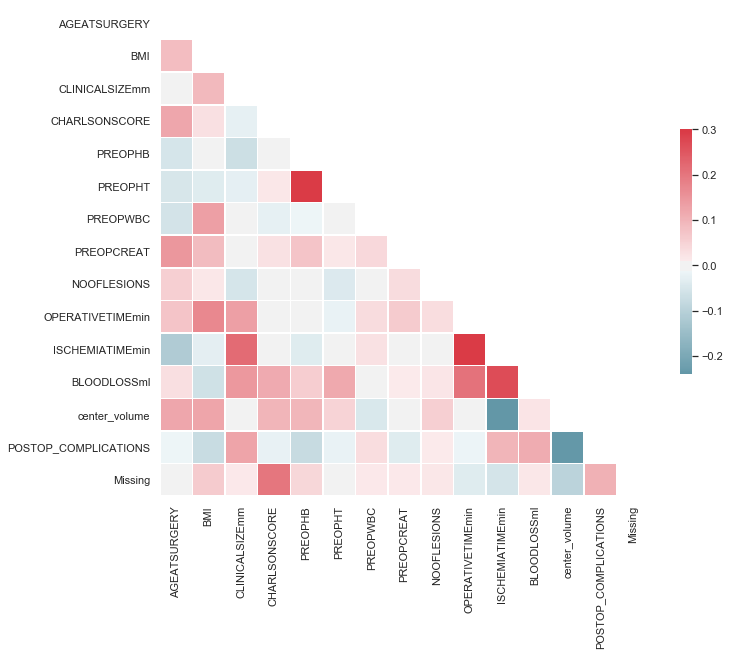

In [137]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [138]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 0 to 1430
Data columns (total 62 columns):
PATIENTNUMBER                         1406 non-null object
CENTERCODE                            1406 non-null category
GENDER                                1406 non-null category
AGEATSURGERY                          1404 non-null float64
MARITALSTATUS                         1406 non-null category
RACE                                  1406 non-null category
EDUCATION                             1406 non-null category
BMI                                   1318 non-null float64
CLINICALSIZEmm                        1363 non-null float64
CHARLSONSCORE                         1331 non-null float64
SYMPTOMS                              1406 non-null category
SOLITARYKIDNEY                        1406 non-null category
BILATERALITYOFTUMOR                   1406 non-null category
SIDEOFTUMOR                           1406 non-null category
SIDEOFSURGERY                         1406 no

In [139]:
df.reset_index(drop=True, inplace=True)
print("Number records for predicting 30 day complications: {}".format(len(df)))

Number records for predicting 30 day complications: 1406


In [140]:
for i in df.select_dtypes('category').columns:
    df[i] = df[i].apply(str)

In [141]:
# fit label encoder to each column of type category
cat_col =df.select_dtypes('category')
df_codes = df.copy()
from sklearn.preprocessing import LabelEncoder
le_dict = {col: LabelEncoder() for col in cat_col }
for col in cat_col:
    le_dict[col].fit_transform(df_codes[col])

In [142]:
# create a dictionary cantaining mapping of categorical values to numerical values
label_mapping = dict()
label_mapping = {col: dict(zip(le_dict[col].classes_,le_dict[col].transform(le_dict[col].classes_))) for col in cat_col}
label_mapping

{'CENTERCODE': {'08ZMCILJ': 0,
  '0VZRZWAI': 1,
  '39HIP3LQ': 2,
  '3QWOG020': 3,
  '4M49I4D5': 4,
  '4UPDM0XB': 5,
  '57T3OUKU': 6,
  '63DCGHNW': 7,
  '94ISQMHX': 8,
  'FWL0MH42': 9,
  'GCIEYK6L': 10,
  'GQHLD5Q4': 11,
  'QRJWT5QR': 12,
  'RETM03Y8': 13,
  'U5WT3NOY': 14,
  'VNO3BPES': 15,
  'VRVRQ639': 16,
  'WGC7XYXZ': 17},
 'GENDER': {'Female': 0, 'Male': 1},
 'MARITALSTATUS': {'Divorced': 0,
  'Married': 1,
  'NA': 2,
  'Single': 3,
  'Widowed': 4},
 'RACE': {'Black': 0,
  'Mongoloid/Asian': 1,
  'NA': 2,
  'Others': 3,
  'White/Caucasian': 4},
 'EDUCATION': {'Graduate': 0,
  'NA': 1,
  'Not Provided': 2,
  'Post Graduate': 3,
  'Upto High School': 4},
 'SYMPTOMS': {'Absent': 0,
  'Local Symptoms': 1,
  'NA': 2,
  'Systemic Symptoms': 3},
 'SOLITARYKIDNEY': {'NA': 0, 'No': 1, 'Yes': 2, 'no': 3},
 'BILATERALITYOFTUMOR': {'NA': 0, 'No': 1, 'Yes': 2},
 'SIDEOFTUMOR': {'Bilateral': 0, 'Left': 1, 'NA': 2, 'Right': 3},
 'SIDEOFSURGERY': {'Bilateral': 0, 'Left': 1, 'Right': 2},
 'FACE': 

In [143]:
# mapping categorical column values to integer labels
for col in cat_col:
    df_codes[col] = le_dict[col].transform(df_codes[col]).copy()

In [144]:
df_codes.head()

,PATIENTNUMBER,CENTERCODE,GENDER,AGEATSURGERY,MARITALSTATUS,RACE,EDUCATION,BMI,CLINICALSIZEmm,CHARLSONSCORE,SYMPTOMS,SOLITARYKIDNEY,BILATERALITYOFTUMOR,SIDEOFTUMOR,SIDEOFSURGERY,FACE,TUMORlOCATION,PREOPHB,PREOPHT,PREOPWBC,PREOPCREAT,PADUARISK,POLARLOCATION,RIMLOCATION,RENALSINUS,EXOPHYTICRATE,CLINICALSIZEGROUP,CT,CN,R.E.N.A.L.NEPHRORISKSTRATIFICATION,RADIUSmaximaldiameterincm,NEARNESSOFTUMOUR,ANTERIORORPOSTERIOR,LOCATIONTOPOLARLINE,ASASCORE,PARTIALNEPHROINDICATION,MULTIFOCALITY,NOOFLESIONS,ACCESS,DAVINCIMODEL,ROBOTICSARMS,ASSISTENTTROCARS,DUALCONSOLE,OPERATIVETIMEmin,ISCHEMIA,CLAMPARTERY,SELECTIVEARTERIALCLAMPING,CLAMPVEIN,EARLYUNCLAMPING,FLUORESCENCE,INNERRENORRHAPHY,OUTERRENORRHAPHY,ISCHEMIATIMEmin,UCSREPAIR,HAEMOSTATICAGENTS,LYMPHNODEDISSECTIONLND,BLOODLOSSml,INTRAOPTRANSUFUSION,INTRAOPCOMPLICATIONS,center_volume,POSTOP_COMPLICATIONS,Missing
0,22PAT000131,17,1,58.0,1,1,2,23.18,44.0,0.0,0,1,1,1,1,0,2,14.0,41.0,5100.0,0.90,3,1,0,2,1,0,2,1,3,0,0,0,2,0,1,1,1.0,2,3,0,0,1,170.0,3,0,1,2,1,1,2,2,21.0,1,1,1,300.0,3,5,26.0,1,0.0
1,11PAT000166,1,1,56.0,1,1,2,23.36,NaN,0.0,0,1,1,1,1,0,0,10.2,36.4,5200.0,0.70,1,2,2,1,1,1,1,1,1,1,1,0,0,0,1,1,1.0,2,3,1,2,1,160.0,3,0,1,2,1,1,1,1,20.0,1,1,1,75.0,3,5,105.0,1,2.0
2,15PAT000097,15,0,65.0,1,4,2,26.67,NaN,0.0,0,1,1,1,1,1,4,11.8,36.0,5300.0,1.12,1,2,2,1,0,1,1,1,1,1,2,2,0,1,1,1,1.0,2,2,0,0,1,212.0,3,0,1,2,1,1,2,2,13.0,1,1,1,50.0,3,5,140.0,1,3.0
3,15PAT000095,15,0,23.0,3,4,2,19.65,23.0,0.0,0,1,1,3,2,2,3,13.3,39.2,12100.0,0.70,3,1,0,2,2,1,1,1,3,1,0,3,2,0,1,1,1.0,2,3,0,0,1,174.0,3,0,1,2,1,1,2,2,11.0,1,1,1,20.0,3,5,137.0,0,2.0
4,15PAT000088,15,0,44.0,3,4,2,29.30,57.0,0.0,1,1,1,1,1,2,2,13.5,41.3,6300.0,0.83,3,1,2,2,1,0,2,1,2,0,0,3,1,1,1,1,1.0,2,2,0,0,1,108.0,3,0,1,2,1,1,2,2,23.0,1,1,1,NaN,3,5,130.0,0,2.0


### Create Stats for dataset

In [145]:
# print median , IQR for numeric columns 
for i in df.columns:#['AGEATSURGERY','BMI','CLINICALSIZEmm','PREOPHB','PREOPHT','PREOPWBC','PREOPCREAT','PREOPEGFR','NOOFLESIONS']:
    if i in numeric_col_list+ ['center_volume']:
        print(i, "{0:.1f} [{1:.1f}-{2:.1f}]".format(df[i].median(),df[i].quantile(0.25),df[i].quantile(0.75)))

AGEATSURGERY 57.5 [48.0-66.0]
BMI 26.8 [24.2-30.3]
CLINICALSIZEmm 30.0 [21.0-40.0]
CHARLSONSCORE 1.0 [0.0-2.0]
PREOPHB 14.0 [13.0-15.0]
PREOPHT 42.0 [39.0-45.0]
PREOPWBC 6925.0 [5700.0-8300.0]
PREOPCREAT 0.9 [0.8-1.1]
NOOFLESIONS 1.0 [1.0-1.0]
OPERATIVETIMEmin 160.0 [130.0-189.0]
ISCHEMIATIMEmin 18.0 [14.0-23.0]
BLOODLOSSml 100.0 [50.0-200.0]
center_volume 118.5 [47.0-238.0]


In [146]:
for i in df_codes.columns:
    if i in cat_col:
        print(pd.DataFrame(df_codes[i].apply(lambda x: le_dict[i].inverse_transform([x])[0]).value_counts()))

          CENTERCODE
GCIEYK6L         397
63DCGHNW         172
4UPDM0XB         168
4M49I4D5         125
VNO3BPES          92
08ZMCILJ          89
0VZRZWAI          72
U5WT3NOY          54
QRJWT5QR          50
WGC7XYXZ          37
RETM03Y8          29
GQHLD5Q4          28
57T3OUKU          25
3QWOG020          24
FWL0MH42          16
VRVRQ639          15
39HIP3LQ           7
94ISQMHX           6
        GENDER
Male       923
Female     483
          MARITALSTATUS
Married            1071
Single              132
NA                  121
Widowed              42
Divorced             40
                 RACE
White/Caucasian   734
Others            280
Mongoloid/Asian   226
NA                134
Black              32
                  EDUCATION
Not Provided            576
Graduate                317
Upto High School        200
NA                      172
Post Graduate           141
                   SYMPTOMS
Absent                 1097
Local Symptoms          255
NA                       29


In [147]:
traget_stats = pd.merge(df_codes[['PATIENTNUMBER','POSTOP_COMPLICATIONS','INTRAOPCOMPLICATIONS']],
                        df_ori[['PATIENTNUMBER','SURGICALCOMPLICATIONS','NONSURGICALCOMPLICATIONS','CLAVIENGRADE','LENGTHOFSTAYdays']], 
                        left_on='PATIENTNUMBER', 
                        right_on='PATIENTNUMBER').copy()

In [148]:
traget_stats['CLAVIENGRADE'].value_counts()

Grade 0: Absence of any complication                                                                                                                                                                       1058
Grade 1: Any deviation from the normal postoperative course, including the need for pharmacologic treatment other than antiemetics, antipyretics, analgesics, diuretics, electrolytes, or physiotherapy      57
Grade 3: Complications needing surgical, endoscopic, or radiologic intervention                                                                                                                              12
Grade 2: Complications needing only use of intravenous medications, total parenteral nutrition, enteral nutrition, or blood transfusion                                                                      11
Grade 4: Life-threatening complication requiring intensive care/intensive care unit (ICU) management                                                                    

In [149]:
traget_stats[traget_stats['POSTOP_COMPLICATIONS']==1]['CLAVIENGRADE'].value_counts()

Grade 0: Absence of any complication                                                                                                                                                                       181
Grade 1: Any deviation from the normal postoperative course, including the need for pharmacologic treatment other than antiemetics, antipyretics, analgesics, diuretics, electrolytes, or physiotherapy     35
Grade 3: Complications needing surgical, endoscopic, or radiologic intervention                                                                                                                             12
Grade 2: Complications needing only use of intravenous medications, total parenteral nutrition, enteral nutrition, or blood transfusion                                                                      6
Grade 4: Life-threatening complication requiring intensive care/intensive care unit (ICU) management                                                                        

In [150]:
sum(traget_stats['LENGTHOFSTAYdays']>4)

290

In [151]:
# Check a point-biserial correlation to check if the relationhsip exists between continuous (predictore) and binary (target)

from scipy import stats
prob = 0.95
selected_num_features = []
for col in df.select_dtypes('float').columns:
    x = df.dropna(axis = 0, subset = [col], how = 'any')
    a = x[col]
    b = x['POSTOP_COMPLICATIONS']
    corr, pvalue = stats.pointbiserialr(a,b)
    if pvalue<=0.05:
        selected_num_features.append(col)
    print("{:<20} | corr = {:>6.2f} | p-value = {:.2f} |".format(col, corr, pvalue))

AGEATSURGERY         | corr =  -0.01 | p-value = 0.65 |
BMI                  | corr =  -0.07 | p-value = 0.01 |
CLINICALSIZEmm       | corr =   0.13 | p-value = 0.00 |
CHARLSONSCORE        | corr =  -0.02 | p-value = 0.42 |
PREOPHB              | corr =  -0.08 | p-value = 0.00 |
PREOPHT              | corr =  -0.02 | p-value = 0.46 |
PREOPWBC             | corr =   0.03 | p-value = 0.23 |
PREOPCREAT           | corr =  -0.04 | p-value = 0.17 |
NOOFLESIONS          | corr =   0.01 | p-value = 0.64 |
OPERATIVETIMEmin     | corr =  -0.01 | p-value = 0.58 |
ISCHEMIATIMEmin      | corr =   0.10 | p-value = 0.00 |
BLOODLOSSml          | corr =   0.11 | p-value = 0.00 |
center_volume        | corr =  -0.24 | p-value = 0.00 |
Missing              | corr =   0.11 | p-value = 0.00 |


In [152]:
# Preform Chi2 test to check if the relationhsip exists between categorical (predictor) and binary (target)

from scipy.stats import chi2_contingency
from scipy.stats import chi2
prob = 0.95
slected_col_features = []
for col in cat_col:
    if col in df.columns:
        table = pd.crosstab(df[col],df['POSTOP_COMPLICATIONS'])
        stat, p, dof, expected = chi2_contingency(table.to_numpy())
        critical = chi2.ppf(prob, dof)
        if p <=0.5:
            slected_col_features.append(col)
        print("{:<35} | stat = {:>6.2f} | critical = {:>6.2f} | dof = {:>2}| p = {:>6.2f}|".format(col,stat,critical,dof,p))
        

CENTERCODE                          | stat = 338.12 | critical =  27.59 | dof = 17| p =   0.00|
GENDER                              | stat =   1.60 | critical =   3.84 | dof =  1| p =   0.21|
MARITALSTATUS                       | stat =  73.63 | critical =   9.49 | dof =  4| p =   0.00|
RACE                                | stat = 118.46 | critical =   9.49 | dof =  4| p =   0.00|
EDUCATION                           | stat = 129.27 | critical =   9.49 | dof =  4| p =   0.00|
SYMPTOMS                            | stat =   9.10 | critical =   7.81 | dof =  3| p =   0.03|
SOLITARYKIDNEY                      | stat =  10.33 | critical =   7.81 | dof =  3| p =   0.02|
BILATERALITYOFTUMOR                 | stat =  59.09 | critical =   5.99 | dof =  2| p =   0.00|
SIDEOFTUMOR                         | stat =  60.78 | critical =   7.81 | dof =  3| p =   0.00|
SIDEOFSURGERY                       | stat =   3.86 | critical =   5.99 | dof =  2| p =   0.15|
FACE                                | st

### Create Train and Test dataset 

In [153]:
df_codes.drop(labels=['Missing'], axis='columns', inplace=True)

In [154]:
df_codes.corr()[target]

CENTERCODE                           -0.144072
GENDER                               -0.035530
AGEATSURGERY                         -0.012269
MARITALSTATUS                        -0.001787
RACE                                 -0.248197
EDUCATION                            -0.140270
BMI                                  -0.073733
CLINICALSIZEmm                        0.125540
CHARLSONSCORE                        -0.022039
SYMPTOMS                             -0.078224
SOLITARYKIDNEY                       -0.049105
BILATERALITYOFTUMOR                  -0.194584
SIDEOFTUMOR                           0.022457
SIDEOFSURGERY                        -0.012150
FACE                                 -0.009646
TUMORlOCATION                        -0.042384
PREOPHB                              -0.076115
PREOPHT                              -0.019869
PREOPWBC                              0.033994
PREOPCREAT                           -0.036577
PADUARISK                             0.018461
POLARLOCATION

In [155]:
print('Number of patients {}'.format(len(df_codes)))
print('% of patients with complications {:.2f}%'.format(sum(df_codes[target])/len(df_codes)*100))

Number of patients 1406
% of patients with complications 20.98%


In [156]:
output_path = 'H:\RediMinds\VCQI'
df_codes.to_csv(output_path+"\VCQI_clean_30_day_complications.csv",index=False)

In [157]:
# Split data in test and train
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_codes, test_size=0.30, random_state=42, stratify = df_codes[target])

In [158]:
# Percentage of complications in trainset
train[target].sum()/len(train)

0.20934959349593496

In [159]:
# Percentage of complications in testset
test[target].sum()/len(test)

0.2109004739336493

In [160]:
# Save train and test dataset
train.to_csv(output_path+"\VCQI_clean_train_30_day_complications.csv",index=False)
test.to_csv(output_path+"\VCQI_clean_test_30_day_complications.csv",index=False)

In [161]:
import pickle

cat_col = df.select_dtypes('category')

with open(output_path+'\cat_col_30_day_complications', 'wb') as fp:
    pickle.dump(cat_col.columns.to_list(), fp)

### Generate Evaluvation Metrics for PADUA Score and RENAL Score 

In [162]:
x = test.loc[test['PADUARISK']!=4][['PADUARISK',target]].copy()
x['Pred'] = x['PADUARISK'].apply(lambda y: 1 if y==3 else 0)
from sklearn import metrics
print(metrics.classification_report(x[target], x['Pred']))
print(metrics.confusion_matrix(x[target], x['Pred']))

              precision    recall  f1-score   support

           0       0.80      0.68      0.74       292
           1       0.26      0.40      0.32        82

    accuracy                           0.62       374
   macro avg       0.53      0.54      0.53       374
weighted avg       0.68      0.62      0.65       374

[[199  93]
 [ 49  33]]


In [163]:
x = test.loc[test['R.E.N.A.L.NEPHRORISKSTRATIFICATION']!=4][['R.E.N.A.L.NEPHRORISKSTRATIFICATION',target]].copy()
x['Pred'] = x['R.E.N.A.L.NEPHRORISKSTRATIFICATION'].apply(lambda y: 1 if y==3 else 0)
from sklearn import metrics
print(metrics.classification_report(x[target], x['Pred']))
print(metrics.confusion_matrix(x[target], x['Pred']))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       287
           1       0.19      0.11      0.14        81

    accuracy                           0.70       368
   macro avg       0.48      0.49      0.48       368
weighted avg       0.65      0.70      0.67       368

[[249  38]
 [ 72   9]]
